# Chapter 7: Compose

In this notebook, we will be using a stacked LSTM network with an _attenion mechanism_ to generate new music.

Attention mechanisms are a technique originally used for machine translation. In a normal encoder-decoder network, we encode input sequences as a single context vector. This can be a bottleneck for how much information a model can retain about the text. Attention mechanics provide a solution to this problem by replacing a single context vector with a weighted sum of the hidden states of the RNN cell during each timestep.

Each hidden state is passed through a dense layer, known as the _alignment function_, with a softmax activation layer. We then multiply the hidden state at each timestep by the output of the dense layer and the result is summed over each step of the sequence.

## Preparing the Training Data

First we download the data for training the model.

In [0]:
!mkdir -p data

In [0]:
import subprocess

music_filenames = ['cs1-2all.mid',
                   'cs5-1pre.mid',
                   'cs4-1pre.mid',
                   'cs3-5bou.mid',
                   'cs1-4sar.mid',
                   'cs2-5men.mid',
                   'cs3-3cou.mid',
                   'cs2-3cou.mid',
                   'cs1-6gig.mid',
                   'cs6-4sar.mid',
                   'cs4-5bou.mid',
                   'cs4-3cou.mid',
                   'cs5-3cou.mid',
                   'cs6-5gav.mid',
                   'cs6-6gig.mid',
                   'cs2-1pre.mid',
                   'cs3-1pre.mid',
                   'cs3-6gig.mid',
                   'cs2-6gig.mid',
                   'cs2-4sar.mid',
                   'cs3-4sar.mid',
                   'cs1-5men.mid',
                   'cs1-3cou.mid',
                   'cs6-1pre.mid',
                   'cs2-2all.mid',
                   'cs3-2all.mid',
                   'cs1-1pre.mid',
                   'cs5-2all.mid',
                   'cs4-2all.mid',
                   'cs5-5gav.mid',
                   'cs4-6gig.mid',
                   'cs5-6gig.mid',
                   'cs5-4sar.mid',
                   'cs4-4sar.mid',
                   'cs6-3cou.mid']
url_prefix = 'http://www.jsbach.net/midi/'
data_dir = 'data/'

In [5]:
for fname in music_filenames:
  print('Downloading ', fname)
  subprocess.call(['wget', url_prefix + fname])
  subprocess.call(['mv', fname, data_dir])

Then we parse each file into a list of notes and durations.

In [0]:
SEQUENCE_LENGTH = 32

In [7]:
from music21 import converter, chord, note

notes = []
durations = []

for fname in music_filenames:
  print('Parsing ', fname)
  original_score = converter.parse(data_dir + fname).chordify()
  score = original_score.transpose(0)
  notes.extend(['START'] * SEQUENCE_LENGTH)
  durations.extend([0] * SEQUENCE_LENGTH)
  for el in original_score.flat:
    if isinstance(el, chord.Chord):
      notes.append('.'.join(n.nameWithOctave for n in el.pitches))
    elif isinstance(el, note.Note):
      notes.append(str(el.name) if el.isRest
                   else notes.append(el.nameWithOctave))   
    durations.append(el.duration.quarterLength)

Parsing  cs1-2all.mid
Parsing  cs5-1pre.mid
Parsing  cs4-1pre.mid
Parsing  cs3-5bou.mid
Parsing  cs1-4sar.mid
Parsing  cs2-5men.mid
Parsing  cs3-3cou.mid
Parsing  cs2-3cou.mid
Parsing  cs1-6gig.mid
Parsing  cs6-4sar.mid
Parsing  cs4-5bou.mid
Parsing  cs4-3cou.mid
Parsing  cs5-3cou.mid
Parsing  cs6-5gav.mid
Parsing  cs6-6gig.mid
Parsing  cs2-1pre.mid
Parsing  cs3-1pre.mid
Parsing  cs3-6gig.mid
Parsing  cs2-6gig.mid
Parsing  cs2-4sar.mid
Parsing  cs3-4sar.mid
Parsing  cs1-5men.mid
Parsing  cs1-3cou.mid
Parsing  cs6-1pre.mid
Parsing  cs2-2all.mid
Parsing  cs3-2all.mid
Parsing  cs1-1pre.mid
Parsing  cs5-2all.mid
Parsing  cs4-2all.mid
Parsing  cs5-5gav.mid
Parsing  cs4-6gig.mid
Parsing  cs5-6gig.mid
Parsing  cs5-4sar.mid
Parsing  cs4-4sar.mid
Parsing  cs6-3cou.mid


In [8]:
notes[SEQUENCE_LENGTH:SEQUENCE_LENGTH+10]

['B3', 'G2.D3.B3', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'E3', 'F#3']

In [9]:
durations[SEQUENCE_LENGTH:SEQUENCE_LENGTH+10]

[0.0, 0.0, 0.0, 0.0, 3.75, 0.0, 0.25, 1.0, 0.25, 0.25]

In [0]:
def get_distinct(elems):
  """Get all distinct elements in a list, sorted."""
  result = sorted(set(elems))
  return result, len(result)

def create_lookup_tables(elems):
  """Generate tokenization lookup table (and inverse table)."""
  return ({e: i for i, e in enumerate(elems)},
          {i: e for i, e in enumerate(elems)})

In [0]:
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)

note_to_int, int_to_note = create_lookup_tables(note_names)
duration_to_int, int_to_duration = create_lookup_tables(duration_names)

Finally we process the training data into 2 sequences of tokens. The output of the model is one-hot encoded, the number of categories for each sequence being the the number of notes and durations respectively.

In [12]:
%tensorflow_version 1.x
from keras.utils import np_utils
import numpy as np

X_notes, X_durations = [], []
y_notes, y_durations = [], []

for i in range(len(notes) - SEQUENCE_LENGTH):
  notes_seq_out = notes[i + SEQUENCE_LENGTH]
  durations_seq_out = durations[i + SEQUENCE_LENGTH]
  
  X_notes.append([note_to_int[n]
                  for n in notes[i:i + SEQUENCE_LENGTH]])
  X_durations.append([duration_to_int[d]
                      for d in durations[i:i + SEQUENCE_LENGTH]])
  
  y_notes.append(note_to_int[notes[i + SEQUENCE_LENGTH]])
  y_durations.append(duration_to_int[durations[i + SEQUENCE_LENGTH]])

n_patterns = len(X_notes)

X_notes = np.reshape(X_notes, (n_patterns, SEQUENCE_LENGTH))
X_durations = np.reshape(X_durations, (n_patterns, SEQUENCE_LENGTH))
X_train = [X_notes, X_durations]

y_notes = np_utils.to_categorical(y_notes, num_classes=n_notes)
y_durations = np_utils.to_categorical(y_durations, num_classes=n_durations)
y_train = [y_notes, y_durations]

TensorFlow 1.x selected.


Using TensorFlow backend.


In [13]:
X_train[0][10]

array([386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386,
       386, 386, 386, 386, 386, 386, 386, 386, 386,  77, 340,  77,  27,
       371, 260, 371, 168, 237, 260])

In [14]:
X_train[1][10]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, 20,  0,  3,  8,  3,  3])

In [15]:
y_train[0][10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [16]:
y_train[1][10]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)

## Building the Model

Below I will define a class which implements a stacked LSTM with an attention mechanism for generating new music. 

In [0]:
# Mount drive.

from google.colab import drive

drive.mount('/content/gdrive/')
weights_dir = '/content/gdrive/My Drive/gdl_models/music_lstm/'

In [0]:
from tensorflow.keras.layers import (Input, Embedding, Concatenate, LSTM, Dense,
                                     Reshape, Activation, Permute, RepeatVector,
                                     Multiply, Lambda)
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop
import os


class AttentionMechanism(object):
  """LSTM with attention mechanism for generating new music."""
  
  def __init__(self, embedding_dim=100, rnn_units=256, use_attention=True):
    notes_in = Input(shape=(None,))
    durations_in = Input(shape=(None,))
    x1 = Embedding(n_notes, embedding_dim)(notes_in)
    x2 = Embedding(n_durations, embedding_dim)(durations_in)
    x = Concatenate()([x1, x2])
    x = LSTM(rnn_units, return_sequences=True)(x)
    if use_attention:
      x = LSTM(rnn_units, return_sequences=True)(x)
      e = Dense(1, activation='tanh')(x)
      e = Reshape([-1])(e)
      alpha = Activation('softmax')(e)
      alpha_repeated = Permute([2, 1])(RepeatVector(rnn_units)(alpha))
      c = Multiply()([x, alpha_repeated])
      c = Lambda(lambda x_in: K.sum(x_in, axis=1), output_shape=(rnn_units,))(c)
    else:
      c = LSTM(rnn_units)(x)
    notes_out = Dense(n_notes, activation='softmax', name='pitch')(c)
    durations_out = Dense(n_durations, activation='softmax', name='duration')(c)
    self.model = Model([notes_in, durations_in], [notes_out, durations_out])
    if use_attention:
      self.attention_model = Model([notes_in, durations_in], alpha)
    else:
      self.attention_model = None
    opt = RMSprop(lr=0.001)
    self.model.compile(loss=['categorical_crossentropy',
                             'categorical_crossentropy'],
                       optimizer=opt)

  def train(self, X_train, y_train, epochs=2000000, batch_size=32,
            weights_dir=weights_dir, initial_epoch=0):
    """Train the model."""
    if initial_epoch > 0:
      self.model.load_weights(
          weights_dir + 'weights-{}.hdf5'.format(initial_epoch))
    callbacks = [EarlyStopping(monitor='loss', patience=10,
                               restore_best_weights=True),
                 ModelCheckpoint(
                     os.path.join(weights_dir, 'weights-{epoch:d}.hdf5'),
                     monitor='loss', verbose=0, save_best_only=True,
                     mode='min'),
                 ModelCheckpoint(
                     os.path.join(weights_dir, 'weights.hdf5'),
                     monitor='loss', verbose=0, save_best_only=True,
                     mode='min')]
    self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                   callbacks=callbacks, shuffle=True,
                   initial_epoch=initial_epoch)              

In [0]:
att_mech = AttentionMechanism()

In [20]:
att_mech.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    38700       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    2300        input_2[0][0]                    
______________________________________________________________________________________________

## Training

Now we will train the model, after 144 epochs the model converges and early stopping ends training.

In [0]:
att_mech.train(X_train, y_train)

## Generating a New Sequence of Notes

In [0]:
notes = ['START', 'D3', 'D3', 'E3', 'D3', 'G3', 'F#3','D3', 'D3', 'E3', 'D3',
         'G3', 'F#3','D3', 'D3', 'E3', 'D3', 'G3', 'F#3','D3', 'D3', 'E3', 'D3',
         'G3', 'F#3']
durations = [0, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1,
             1, 1, 2, 0.75, 0.25, 1, 1, 1, 2]

notes = ['START'] * (SEQUENCE_LENGTH - len(notes)) + notes
durations = [0] * (SEQUENCE_LENGTH - len(durations)) + durations

In [0]:
def sample_with_temperature(preds, temp):
  """Sample new predictions with a temperature for some randomness."""
  if temp == 0.0:
    return np.argmax(preds)
  preds = np.exp(np.log(preds) / temp)
  preds /= np.sum(preds)
  return np.random.choice(len(preds), p=preds)

In [0]:
N_NEW_NOTES = 128

prediction_output = []
notes_input_sequence = [note_to_int[n] for n in notes]
durations_input_sequence = [duration_to_int[d] for d in durations]

overall_preds = []

att_matrix = np.zeros(shape=(N_NEW_NOTES + SEQUENCE_LENGTH, N_NEW_NOTES))

In [64]:
att_mech.model.load_weights(weights_dir + 'weights.hdf5')

for note_idx in range(N_NEW_NOTES):
  pred_input = [np.array([notes_input_sequence]),
                np.array([durations_input_sequence])]
  notes_pred, durations_pred = att_mech.model.predict(pred_input, verbose=0)

  att_pred = att_mech.attention_model.predict(pred_input, verbose=0)[0]
  att_matrix[(note_idx - len(att_pred) + SEQUENCE_LENGTH):(
      note_idx + SEQUENCE_LENGTH), note_idx] = att_pred

  new_note = np.zeros(128)
  for idx, n_i in enumerate(notes_pred[0]):
    try:
      midi_note = note.Note(int_to_note[idx])
      new_note[midi_note.pitch.midi] = n_i
    except:
      pass
  overall_preds.append(new_note)

  n = sample_with_temperature(notes_pred[0], 0.2)
  d = sample_with_temperature(durations_pred[0], 0.2)
  prediction_output.append([int_to_note[n], int_to_duration[d]])

  notes_input_sequence.append(n)
  durations_input_sequence.append(d)

  if len(notes_input_sequence) > SEQUENCE_LENGTH:
    notes_input_sequence = notes_input_sequence[1:]
    durations_input_sequence = durations_input_sequence[1:]

  if int_to_note[n] == 'START':
    break

overall_preds = np.transpose(np.array(overall_preds))
print('Generated sequence of {} notes'.format(len(prediction_output)))

Generated sequence of 128 notes


### Plotting the Model Predictions

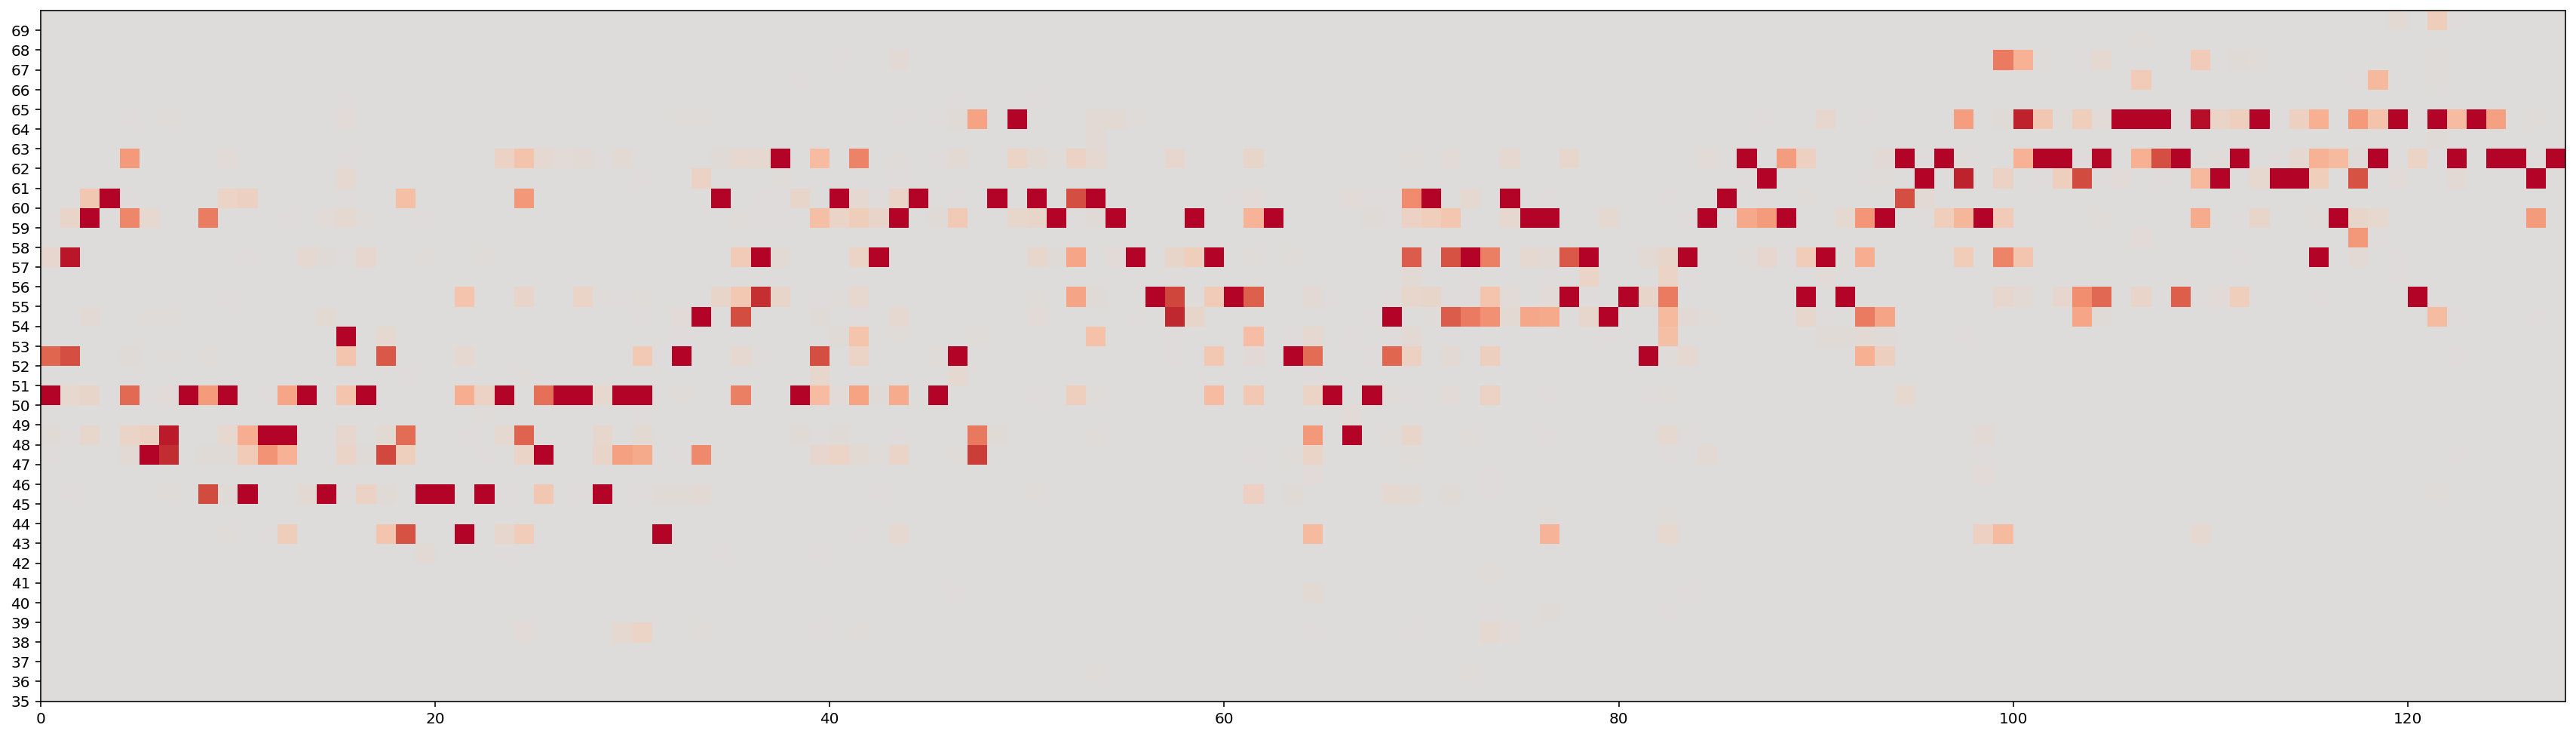

In [65]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30, 15))
ax.set_yticks([j for j in range(35, 70)])
plt.imshow(overall_preds[35:70,:], origin='lower', cmap='coolwarm', vmin=-0.5,
           vmax=0.5, extent=[0, N_NEW_NOTES, 35, 70])

### Playing the Predicted Audio

In [78]:
from music21 import stream, duration, instrument, tempo

midi_stream = stream.Stream()
midi_stream.append(instrument.Violoncello())
midi_stream.append(tempo.MetronomeMark(number=80))

for pattern in prediction_output:
  note_pattern, duration_pattern = pattern
  if '.' in note_pattern:
    chord_notes = []
    for n in note_pattern.split(''):
      new_note = note.Note(n)
      new_note.duration = duration.Duration(duration_pattern)
      chord_notes.append(new_note)
    new_chord = chord.Chord(chord_notes)
    midi_stream.append(new_chord)
  elif note_pattern == 'rest':
    new_note = note.Rest()
    new_note.duration = duration.Duration(duration_pattern)
    midi_stream.append(new_note)
  else:
    new_note = note.Note(note_pattern)
    new_note.duration = duration.Duration(duration_pattern)
    midi_stream.append(new_note)

midi_stream = midi_stream.chordify()
midi_stream.write('midi', fp='out.mid')

'out.mid'

In [0]:
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

In [79]:
!fluidsynth -i font.sf2 out.mid -F out.wav -r 1000

FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'out.wav'..


In [83]:
from IPython.display import Audio
from scipy.io import wavfile

rate, data = wavfile.read('out.wav')
Audio(data.T, rate=rate, autoplay=True)

### Plotting the Attention Matrix